# Covalent ligands

This notebook explores the impact of covalently bound ligands on the performance of the docking algorithms **Fred**, **Hybrid** and **Posit**.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)
docking_benchmark_dataset = pd.read_csv("../data/docking_benchmark_dataset.csv", index_col=0)
print(f"Total number of structures in benchmark: {len(docking_benchmark_dataset)}")
n_covalent_ligands = sum(docking_benchmark_dataset["covalent_ligand"])
print(f"Number of structures in benchmark with covalent ligand: {n_covalent_ligands}")

Total number of structures in benchmark: 589
Number of structures in benchmark with covalent ligand: 11


In [5]:
# apply covalent categories to results
covalent_pdb_ids = docking_benchmark_dataset[docking_benchmark_dataset["covalent_ligand"]]["structure.pdb_id"].to_list()
for results in [fred_results, hybrid_results, posit_results]:
    results.loc[:, "covalent_category"] = "None"
    covalent_bound_indices = results[results["protein_pdb_id"].isin(covalent_pdb_ids)].index
    results.loc[covalent_bound_indices, "covalent_category"] = "bound"
    covalent_docked_indices = results[results["ligand_pdb_id"].isin(covalent_pdb_ids)].index
    results.loc[covalent_docked_indices, "covalent_category"] = "docked"
    covalent_bound_and_docked_indices = [x for x in covalent_bound_indices if x in covalent_docked_indices]
    results.loc[covalent_bound_and_docked_indices, "covalent_category"] = "bound+docked"

## Impact of covalent ligands on docking performance

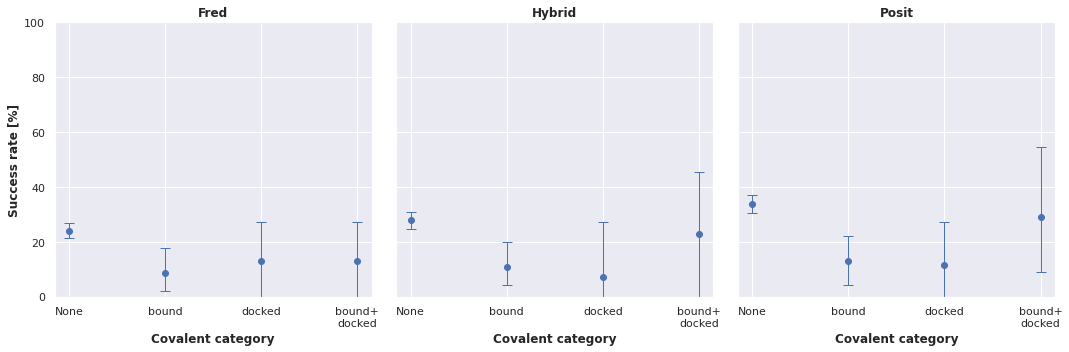

In [6]:
def plot_performance(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 3 subplots
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    
    # sample success rates
    sampled_success_rates = []
    covalent_categories = ["None", "bound", "docked", "bound+docked"]
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for covalent_category in covalent_categories:
            result_selection = results[results["covalent_category"] == covalent_category]
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):  # pick a random structure per ligand
                sampled_results = result_selection.groupby(["ligand_pdb_id"]).sample(n=1)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([covalent_category, method, mean, lower_bound, upper_bound])
            
    # plot sampled data
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, 
        columns=["covalent_category", "method", "success_rate", "ci_lower", "ci_upper"]
    )
    for i, method in enumerate(["Fred", "Hybrid", "Posit"]):
        sampled_success_rates_i = sampled_success_rates[sampled_success_rates["method"] == method]
        axes[i].errorbar(
            x=sampled_success_rates_i["covalent_category"],
            y=sampled_success_rates_i["success_rate"],
            yerr=[
                sampled_success_rates_i["success_rate"] - sampled_success_rates_i["ci_lower"], 
                sampled_success_rates_i["ci_upper"] - sampled_success_rates_i["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1
        )
        axes[i].set_xlabel("Covalent category", fontweight="bold")
        axes[i].set_xticks(["None", "bound", "docked", "bound+docked"])
        axes[i].set_xticklabels(["None", "bound", "docked", "bound+\ndocked"])
        axes[i].set_title(method, fontweight="bold")
    axes[0].set_ylabel("Success rate [%]", fontweight="bold")
    axes[0].set_ylim([0, 100])
    
    plt.tight_layout()
    plt.savefig(directory / "covalent_ligands.pdf", dpi=300)
    
    return sampled_success_rates
        
        
sampled_success_rates = plot_performance(fred_results, hybrid_results, posit_results)

In [7]:
sampled_success_rates

,covalent_category,method,success_rate,ci_lower,ci_upper
0,None,Fred,24.092215,21.280277,26.816609
1,bound,Fred,8.471111,2.222222,17.777778
2,docked,Fred,13.054545,0.000000,27.272727
3,bound+docked,Fred,13.154545,0.000000,27.272727
4,None,Hybrid,27.923702,24.567474,30.968858
5,bound,Hybrid,10.844444,4.444444,20.000000
6,docked,Hybrid,7.309091,0.000000,27.272727
7,bound+docked,Hybrid,22.781818,0.000000,45.454545
8,None,Posit,33.677509,30.622837,37.024221
9,bound,Posit,13.082222,4.444444,22.222222
